# Synaptic Plasticity in rate networks

In [470]:
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch as linepatch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ipywidgets as widgets
import scipy
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec
from urllib.request import urlopen
from PIL import Image
    
circular_colors = [[0.658308, 0.469939, 0.049413],
 [0.744038, 0.407172, 0.156543],
 [0.810445, 0.335882, 0.263072],
 [0.857457, 0.252094, 0.398416],
 [0.872591, 0.166185, 0.578329],
 [0.836934, 0.161108, 0.76804],
 [0.753424, 0.255361, 0.899179],
 [0.636852, 0.359561, 0.954059],
 [0.49199, 0.449706, 0.941785],
 [0.321912, 0.520685, 0.862792],
 [0.171942, 0.563517, 0.737535],
 [0.096568, 0.584234, 0.611819],
 [0.045551, 0.598018, 0.485098],
 [0.14238, 0.603831, 0.323267],
 [0.368179, 0.578986, 0.125801],
 [0.543825, 0.52618, 0.052752]]


%matplotlib inline

# Settings for the figures
plt.style.use(plt.style.available[20])
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")


# Overview of the different plasticity rules

\begin{align}
ρ =& \; \text{presynaptic rate} \\
v =& \; \text{postsynaptic rate}
\end{align}

Simple Hebbian rule:
\begin{equation}
    \tau \dot{w} = \; v ρ
\end{equation}

If we want to do some analysis on the weight evolution, the simple hebbian rule becomes the correlation based rule:
\begin{equation}
    \tau \dot{w} = \; C w \\ 
    C = ⟨ \rho \rho^{T} ⟩
\end{equation}

\\

Threshold Hebbian rules:
\begin{align}
    \tau \dot{w} =& \; v (ρ - \theta) \\
    \tau \dot{w} =& \; (v - \theta) ρ \\
    \tau \dot{w} =& \; (v - \theta) (ρ - \theta)
\end{align}

The threshold Hebbian rule becomes the covariance based rule (threshold in pre and post, and we select the threshold to be $ ⟨v⟩$ or $ ⟨ρ⟩$):
\begin{equation}
    \tau \dot{w} = \; Q w \\ 
    Q = ⟨ (\nu - ⟨\nu⟩) (\rho - ⟨\rho⟩)^{T}⟩
\end{equation}

\\

Hebbian rule with Subtractive normalization:
\begin{equation}
    \tau \dot{w} = \; Cw - \frac{n^{T}Cw}{n^{T}n}n
\end{equation}

Hebbian rule with Mulitplicative normalization:
\begin{equation}
    \tau \dot{w} = \; Cw - \frac{n^{T}Cw}{n^{T}w}w
\end{equation}

\\

BCM rule:
\begin{align}
    \tau \dot{w} =& \; v(v-θ ) ρ \\
    \tau_{\theta} \dot{\theta}  =& - θ + \frac{\bar{v}^{2}}{\rho}
\end{align}

In [12]:
x = np.array([1,2,3])
y = np.array([0,1,2])

print (np.dot(x[:,None],y[None,:]))
r0 = x.reshape(1,-1)
r1 = y.reshape(-1, 1)
print (r0)
print (np.dot(r1,r0))

[[0 1 2]
 [0 2 4]
 [0 3 6]]
[[1 2 3]]
[[0 0 0]
 [1 2 3]
 [2 4 6]]


In [379]:
def evolve_pre_and_post(r_pre, r_post, w, input_pattern=np.zeros(1)):
       
    dr_post = dt*(-r_post + np.sum(r_pre*w))/tau
    dr_pre = dt*(-r_pre + input_pattern)/tau
    
    return r_pre+dr_pre, r_post+dr_post

In [501]:
def hebbian(r0, r1, tau, dt=0.5, **params):

    dw = (dt/tau) * np.dot(r1[:,None], r0[None,:])
    
    return dw, 0

def hebbian_threshold_pre(r0, r1, theta, tau, dt=0.5, **params):

    dw = (dt/tau) * np.dot(r1[:,None], r0[None,:] - theta)
  
    return dw, 0

def hebbian_threshold_post(r0, r1, theta, tau, dt=0.5, **params):

    dw = (dt/tau) * np.dot(r1[:,None] - theta, r0[None,:])
  
    return dw, 0


def hebbian_subtractive_normalization(r0, r1, tau, dt=0.5, **params):

    dw1 = np.dot(r1[:,None], r0[None,:])   # simple Hebbian term
    dw2 = np.sum(dw1)/np.size(dw1)        # subtractive normalization term
    dw = (dt/tau) * (dw1 - dw2)
    
    return dw, 0

def hebbian_multiplicative_norm(r0, r1, w, tau, dt=0.5, **params):

    dw1 = np.dot(r1[:,None], r0[None,:])      # simple Hebbian term
    dw2 = (np.sum(dw1)/np.sum(w)) * w       # multiplicative normalization term
    dw = (dt/tau) * (dw1 - dw2)
    return dw, 0

def bcm(r0, r1, theta, tau, tau_theta, r_target, dt=0.5, **params):
    
    dw = (dt/tau) * np.dot(r1[:,None]*(r1[:,None]-theta), r0[None,:]) 
    dtheta = (dt/tau_theta) * (-theta + r1[:,None]*r1[:,None]/r_target)

    return dw, dtheta[0,0]

all_plasticity_functions = [
    ('hebbian',hebbian), 
    ('hebbian_threshold_pre',hebbian_threshold_pre),
    ('hebbian_threshold_post',hebbian_threshold_post), 
    ('hebbian_subtractive_normalization',hebbian_subtractive_normalization),
    ('hebbian_multiplicative_norm',hebbian_multiplicative_norm), 
    ('bcm',bcm)]

In [502]:
# simple setup to understand the plasticity rules 

def investigate_plasticity_rules_simple(
    plasticity_rule,
    n_pre = 2,
    upper_bound = 5, 
    theta_start = 0,
    tau_theta = 40,
    r_target = 12):
    
    tau_w = 1000
    dt = 0.1
    time_steps = 4000

    
    r_pre = np.array([4.,1.,2.,0.5])
    r_pre = r_pre[:n_pre]
    w = np.ones_like(r_pre)
    r_post = np.array([0.])
    

    all_pre = r_pre[:]
    all_post = r_post[:]
    all_time = [0]
    all_angles = [mu]
    all_w = np.array([w])
    
    theta = theta_start
    all_theta = [theta]
    
    

    

    for ii in range(time_steps):

        _ , r_post = evolve_pre_and_post(r_pre, r_post, w)


        dw, dtheta = plasticity_rule(r0=r_pre, r1 = r_post, theta=theta, w=w, tau=tau_w, tau_theta=tau_theta, r_target=r_target, dt=dt)
    
        theta += dtheta

        w += dw.flatten()



        w[w<0] = 0
        w[w>upper_bound] = upper_bound




        if ii%15 == 0:
            all_pre = np.vstack([all_pre, r_pre])
            all_post = np.vstack([all_post, r_post])
            all_time.append(ii*dt)
            all_w = np.vstack([all_w,w])
            all_theta.append(theta)
            
        
    fig = plt.figure()
    gs = GridSpec(3, 4)

    # Create subplots using the GridSpec
    ax1 = plt.subplot(gs[0, :-1]) 
    ax2 = plt.subplot(gs[1, :-1], sharex = ax1)  
    ax3 = plt.subplot(gs[2, :-1])  
    ax_img = plt.subplot(gs[:, 3]) 

    
    ax1.plot(all_time,all_post, c='k')
    if plasticity_rule == bcm or plasticity_rule == hebbian_threshold_post:
        ax1.plot(all_time, all_theta, color = 'r', linestyle = '--', linewidth = 0.8, label = 'postsynaptic threshold')
        ax1.legend()
    ax1.set(
        ylabel = 'Postsynaptic activity')
    ax2.plot(all_time,all_w)
    ax2.axhline(y=upper_bound, c='r', label = 'upper bound', linestyle ='--', linewidth=0.8)
    ax2.legend()
    ax2.set(
        ylabel='Weight',
        xlabel = 'Time in ms')
    
    all_ticks = []
    all_tick_names = []
    for ii, rr in enumerate(r_pre):
        x_pos = 2*ii
        ax3.bar([x_pos], rr)
        all_ticks.append(x_pos)
        all_tick_names.append(f'Presynaptic neuron {ii+1}')
    ax3.set_xticks(all_ticks)
    ax3.set_xticklabels(all_tick_names)
    if plasticity_rule == hebbian_threshold_pre:
        ax3.axhline(theta, color = 'r', linestyle = '--', linewidth = 0.8, label = 'presynaptic threshold')
        ax3.legend()
    ax3.set(
        ylabel = 'Presynaptic activity',
        ylim = [0,5],
        xlim = [-1, 2*(len(r_pre)-1)+1])
      

    # Read the image data from the URL
    url = f'https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/notebooks/Exc_7/static/pre_to_post_{len(r_pre)}.png'
    with urlopen(url) as f:
        image = Image.open(f)

    # Convert the image data to a NumPy array
    image_array = np.array(image)

    # Plot the image
    ax_img.imshow(image_array)
    
    
    ax_img.axis('off')
    plt.tight_layout()
    
    

widgets.interactive(investigate_plasticity_rules_simple, 
                    plasticity_rule = all_plasticity_functions,
                   upper_bound = (1,10,1),
                   theta_start = (0,10,1),
                   tau_theta = (0.5,4,0.5),
                   r_target = (0,40,2),
                   n_pre = (1,4,1))

interactive(children=(Dropdown(description='plasticity_rule', options=(('hebbian', <function hebbian at 0x0000…

In [321]:
def create_line_for_angle(n_shift, ax):
        
        x = np.linspace(0,180,17)
        angle = x[n_shift]/360.*2*np.pi


        gain = np.tan(angle)


        line_length = 1
        center = np.array([calc_x_shift(n_shift),0.05])

        a = np.array([np.cos(angle),np.sin(angle)])/60.
        b = np.array([-np.cos(angle),-np.sin(angle)])/60.

        con = ConnectionPatch(
            a+center, 
            b+center, 
            'figure fraction',color=circular_colors[n_shift],linewidth=3)
        ax.add_artist(con)
        
        return con
def calc_x_shift(n_shift):
        
    return 0.12+n_shift*0.053

def create_angle_illustration(ax):
    
    for ii in range(n_pre):
        create_line_for_angle(n_shift=ii,ax=ax)
        
    ax.set_xticklabels([])

    
def gaussian(x, mu, sig):
    x = np.copy(x)
    
    
    
    stacked = np.vstack([np.abs(x-mu),np.abs((x-len(x))-mu),np.abs((x+len(x))-mu)])
    arg = np.argmin(stacked,axis=0)
    
    x[arg == 1] = x[arg == 1]-len(x)
    x[arg == 2] = x[arg == 2]+len(x)
   
    gaussian = np.exp((-((x - mu)/sig)**2.)/2)
    
    norm = np.sum(gaussian)
    
    return gaussian

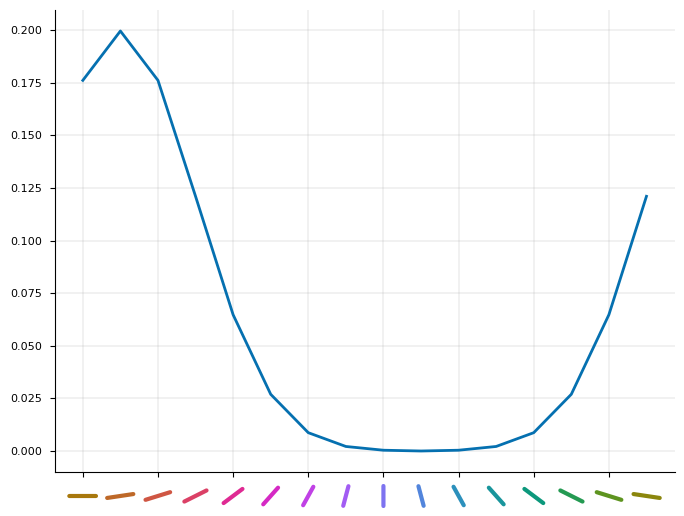

In [176]:
X = np.linspace(0,15,16)
fig, ax = plt.subplots()
ax.plot(X, gaussian(X,mu=1,sig=2))
create_angle_illustration(ax)

# Add the ConnectionPatch object to the plot
# ax.add_artist(con)

In [525]:

n_pre = 16
r_pre = np.zeros(n_pre)
r_post = np.zeros(1)
w = np.ones(n_pre)*0.5
tau = 20
tau_w = 1000
tau_theta = 40
dt = 0.5
time_steps = 4000



X = np.linspace(0,n_pre-1,n_pre)


mu = np.random.choice(n_pre)

all_pre = r_pre[:]
all_post = r_post[:]
all_time = [0]
all_angles = [mu]
all_w = np.array([w])
all_theta = [0]

theta = 0

for ii in range(time_steps):
    
    if np.random.rand() > 0.995:
        mu = np.random.choice(n_pre)
        
    
    input_pattern = gaussian(x=X, mu=mu,sig=2) + 0.0
    r_pre, r_post = evolve_pre_and_post(r_pre, r_post, w, input_pattern)
        
    r_pre = input_pattern
#     dw = hebbian(r0=r_pre, r1 = r_post, tau=tau_w, dt=dt)
    
#     dw = hebbian_threshold(r0=r_pre, r1 = r_post, theta = 1.8, tau=tau_w, dt=dt)
#     dw = hebbian_subtractive_normalization(r0=r_pre, r1 = r_post, tau=tau_w, dt=dt)
    
    dw, _ = hebbian_multiplicative_norm(r0=r_pre, r1 = r_post, w = w, tau=tau_w, dt=dt)
    
#     dw, dtheta = bcm(r0=r_pre, r1 = r_post, theta=theta, tau=tau_w, tau_theta=tau_theta, r_target=8, dt=dt)
    
    theta += dtheta
    
    w += dw.flatten()
    
   
    
    w[w<0] = 0
    w[w>5] = 5

     
    
    
    if ii%15 == 0:
        all_pre = np.vstack([all_pre, r_pre])
        all_post = np.vstack([all_post, r_post])
        all_time.append(ii*dt)
        all_w = np.vstack([all_w,w])
        all_angles.append(mu)
        all_theta.append(theta)

    
def illustrate_results(time_step):
    

    fig, (ax1,ax2,ax3) = plt.subplots(3,1, gridspec_kw={'height_ratios': [1, 3,3]})
    
    
    ax1.plot(all_time[:time_step],all_post[:time_step])
    ax1.set(
        xlim = [0,all_time[-1]],
        ylabel = 'Output rate')
    
#     ax4 = ax1.twinx()
#     ax4.plot(all_time[:time_step],all_theta[:time_step],'r')
    
    for cc, w in zip(circular_colors,all_w[:time_step,:].T):
        ax2.plot(all_time[:time_step],w, c=cc)
    
    ax2.set(
        xlim = [0,all_time[-1]],
        xlabel = 'Time in ms',
        ylabel = 'Input weights')
    
#     ax1.set_ylim([-0.05*np.max(all_w),np.max(all_w)])
    
    
    for ii, (pre,cc) in enumerate(zip(all_pre[time_step],circular_colors)):
        ax3.bar([ii],pre, edgecolor = cc, linewidth = 2, facecolor='#f0f0f0', width=0.5)
    ax3.set(
        ylabel = 'Input Rate',
        ylim = [0,np.max(all_pre)*1.1])
    
    ax3.axvline(all_angles[time_step], linestyle = '--', c='r', label = 'stimulus')
    ax3.legend()
    create_angle_illustration(ax3)
    
    plt.tight_layout()
    
#     for ii in range(time_step):
#         a = [all_time[ii-1],0.95]
#         b = [all_time[ii],0.95]

#         con = ConnectionPatch(
#             a, 
#             b, 
#             'figure fraction',color=circular_colors[all_angles[ii]],linewidth=3)
#         ax1.add_artist(con)
        
    
    
    
    
print (len(all_time))


    

    
widgets.interactive(illustrate_results, time_step = (2,len(all_time)-1,1))




268


interactive(children=(IntSlider(value=134, description='time_step', max=267, min=2), Output()), _dom_classes=(…

In [524]:
        
def calc_x_shift(n_shift):
        
    return 0.14+n_shift*0.0512